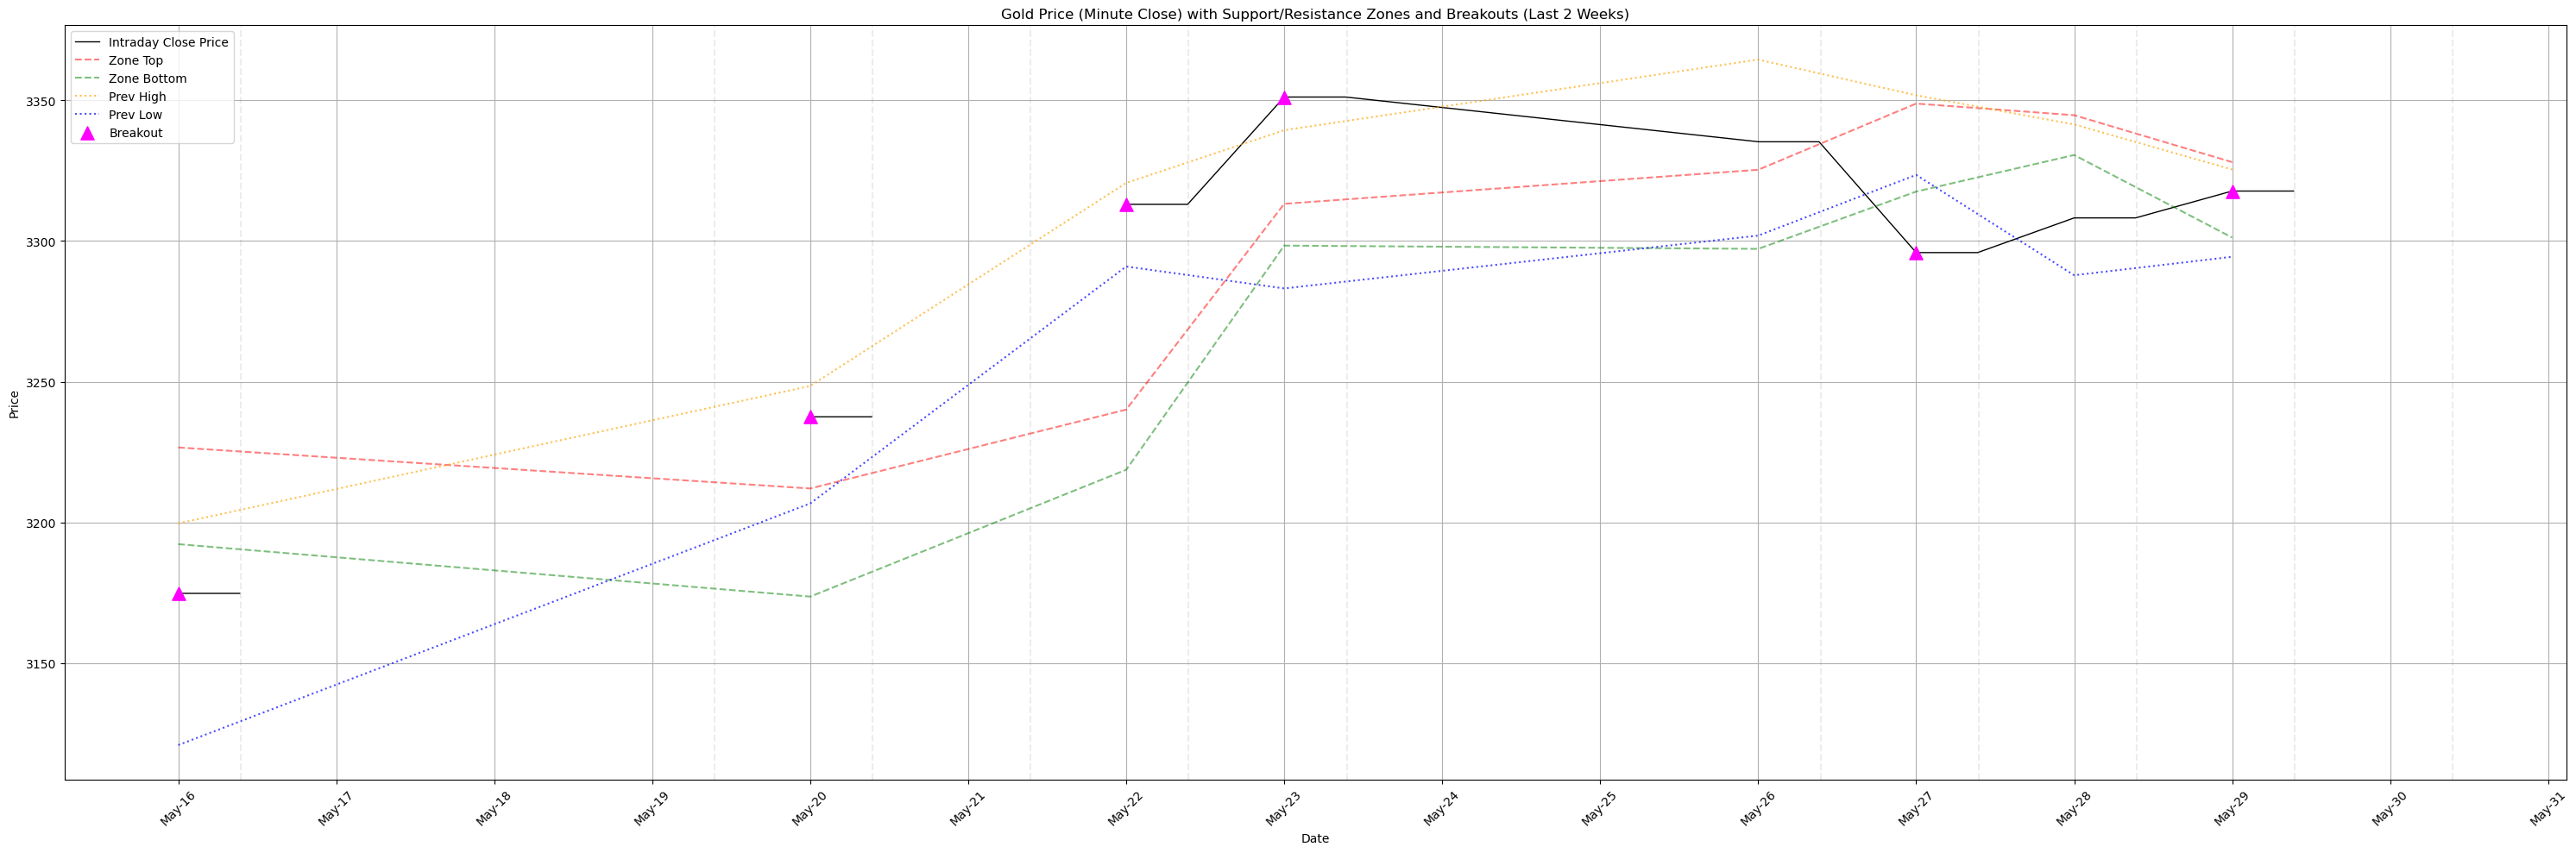

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
pre_df = pd.read_csv("pre_market_data.csv", parse_dates=['time_ny', 'date'])
levels_df = pd.read_csv("support_resistance_features_enhanced.csv", parse_dates=['date'])

# Merge support/resistance features
df = pre_df.merge(levels_df, on='date', how='left')

# Handle duplicated 'close' columns if exist
if 'close_x' in df.columns:
    df = df.drop(columns='close_x')
if 'close_y' in df.columns:
    df = df.rename(columns={'close_y': 'close'})

# Filter data for last 2 weeks
end_date = df['date'].max()
start_date = end_date - pd.DateOffset(weeks=2)
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
levels_df = levels_df[(levels_df['date'] >= start_date) & (levels_df['date'] <= end_date)]

# Aggregate daily close prices for daily reference (last close of each day)
daily = df.groupby('date')['close'].last().reset_index()

# Filter breakout days
breakout_days = levels_df[
    (levels_df['broke_prev_high'] == 1) | 
    (levels_df['broke_prev_low'] == 1)
]

# Merge breakout days with daily closes to get price for breakout markers
breakout_merged = pd.merge(
    breakout_days[['date']],
    daily,
    on='date',
    how='inner'
)

# Start plotting with bigger figure size
fig, ax = plt.subplots(figsize=(30, 10))

# Plot the real intraday price line
df_sorted = df.sort_values('time_ny')
ax.plot(df_sorted['time_ny'], df_sorted['close'], label='Intraday Close Price', color='black', linewidth=1)

# Plot support/resistance zones on daily level
ax.plot(levels_df['date'], levels_df['zone_top'], label='Zone Top', linestyle='--', color='red', alpha=0.5)
ax.plot(levels_df['date'], levels_df['zone_bottom'], label='Zone Bottom', linestyle='--', color='green', alpha=0.5)
ax.plot(levels_df['date'], levels_df['prev_high'], label='Prev High', linestyle=':', color='orange', alpha=0.7)
ax.plot(levels_df['date'], levels_df['prev_low'], label='Prev Low', linestyle=':', color='blue', alpha=0.7)

# Mark breakout points on real price line (using daily close price)
ax.scatter(
    breakout_merged['date'],
    breakout_merged['close'],
    color='magenta',
    marker='^',
    s=120,
    label='Breakout',
    zorder=10
)

# Highlight US market open time (09:30) vertical lines per day
for session_date in df['date'].unique():
    us_open_time = pd.Timestamp(f"{session_date.date()} 09:30:00")
    ax.axvline(us_open_time, color='gray', linestyle='--', alpha=0.15)

# Format x-axis for date/time
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation=45)

# Axis labels and legend
ax.set_title("Gold Price (Minute Close) with Support/Resistance Zones and Breakouts (Last 2 Weeks)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
numeric_cols = df.select_dtypes(include=['number']).columns
print(f"Number of numeric columns: {len(numeric_cols)}")
print("Numeric columns:", list(numeric_cols))

Number of numeric columns: 34
Numeric columns: ['open', 'high', 'low', 'tick_volume', 'close', 'session_volume', 'prev_high', 'prev_low', 'prev_close', 'rolling_high', 'rolling_low', 'zone_mid', 'zone_top', 'zone_bottom', 'vol_zone_top', 'vol_zone_bottom', 'avg_dist_to_prev_high', 'min_dist_to_prev_high', 'avg_dist_to_prev_low', 'max_dist_to_prev_low', 'avg_ratio_to_high', 'avg_ratio_to_low', 'broke_prev_high', 'broke_prev_low', 'breakout_above_magnitude', 'breakout_below_magnitude', 'broke_above_prev_high_sum', 'broke_below_prev_low_sum', 'broke_above_zone_top_sum', 'broke_below_zone_bottom_sum', 'broke_above_prev_close_sum', 'broke_below_prev_close_sum', 'minutes_to_breakout_above_close', 'minutes_to_breakout_below_close']


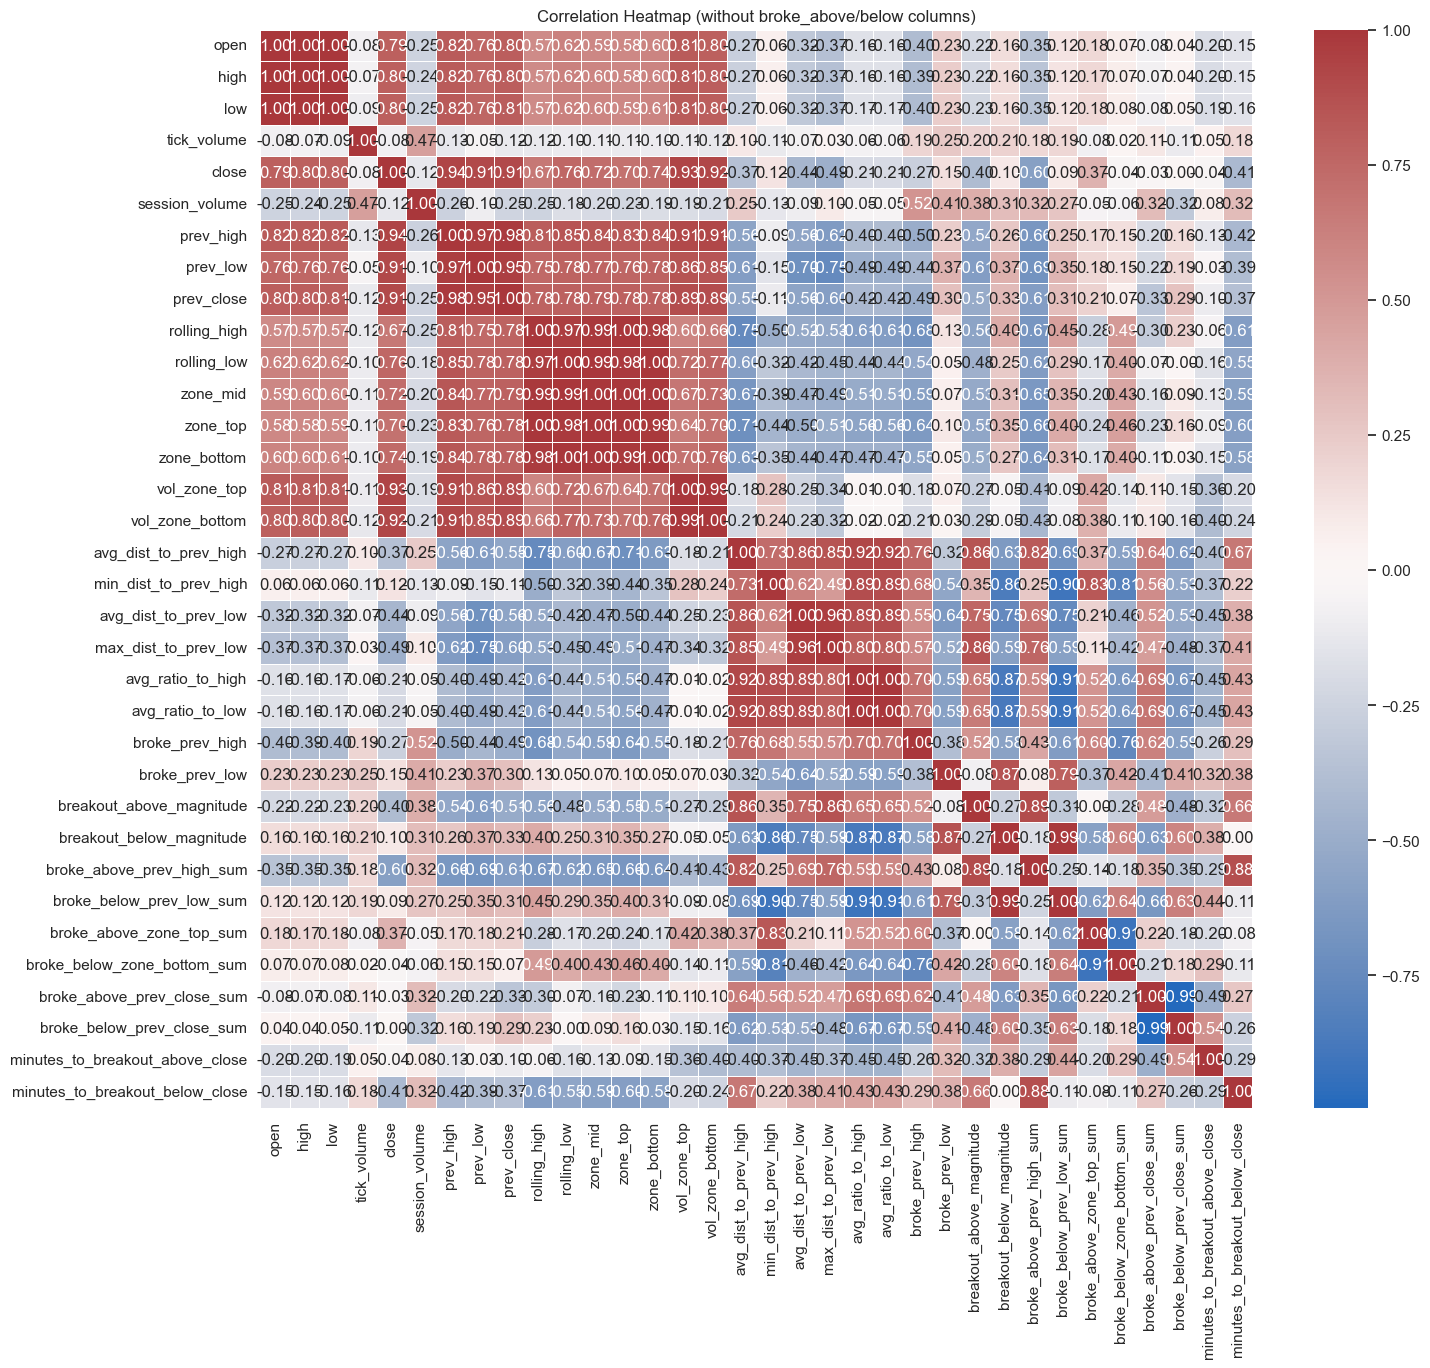

Strong correlations (|corr| ≥ 0.7):

avg_ratio_to_high ↔ avg_ratio_to_low: positive correlation 1.00
open ↔ high: positive correlation 1.00
open ↔ low: positive correlation 1.00
high ↔ low: positive correlation 1.00
rolling_low ↔ zone_bottom: positive correlation 1.00
zone_mid ↔ zone_bottom: positive correlation 1.00
zone_mid ↔ zone_top: positive correlation 1.00
rolling_high ↔ zone_top: positive correlation 1.00
rolling_low ↔ zone_mid: positive correlation 0.99
vol_zone_top ↔ vol_zone_bottom: positive correlation 0.99
zone_top ↔ zone_bottom: positive correlation 0.99
breakout_below_magnitude ↔ broke_below_prev_low_sum: positive correlation 0.99
rolling_high ↔ zone_mid: positive correlation 0.99
rolling_low ↔ zone_top: positive correlation 0.98
prev_high ↔ prev_close: positive correlation 0.98
rolling_high ↔ zone_bottom: positive correlation 0.98
prev_high ↔ prev_low: positive correlation 0.97
rolling_high ↔ rolling_low: positive correlation 0.97
avg_dist_to_prev_low ↔ max_dist_to_prev

In [20]:
# Drop unwanted columns first
df_filtered = df.drop(columns=['broke_above_prev_close_any', 'broke_below_prev_close_any'])

# Select numeric columns
num_cols = df_filtered.select_dtypes(include=[np.number]).columns

# Fill NaNs in numeric columns with median
df_filtered[num_cols] = df_filtered[num_cols].fillna(df_filtered[num_cols].median())

# Now you can get a numeric-only DataFrame safely for correlation
df_numeric = df_filtered[num_cols]

# Compute correlation
corr = df_numeric.corr()

# Plot heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=0.5)
plt.title("Correlation Heatmap (without broke_above/below columns)")
plt.show()

# Function to print strong correlations
def print_strong_correlations(df, threshold=0.7):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    strong_pairs = corr.where(mask).stack().reset_index()
    strong_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    strong_pairs = strong_pairs[strong_pairs['Correlation'].abs() >= threshold].sort_values(by='Correlation', ascending=False)
    
    if strong_pairs.empty:
        print(f"No correlations stronger than ±{threshold} found.")
        return
    
    print(f"Strong correlations (|corr| ≥ {threshold}):\n")
    for _, row in strong_pairs.iterrows():
        direction = "positive" if row['Correlation'] > 0 else "negative"
        print(f"{row['Feature1']} ↔ {row['Feature2']}: {direction} correlation {row['Correlation']:.2f}")

# Print correlations
print_strong_correlations(df_numeric, threshold=0.7)